This notebook addresses [LVV-3771](https://jira.lsstcorp.org/browse/LVV-3771) and [LVV-1739](https://jira.lsstcorp.org/browse/LVV-1739), which specify the median time interval between visits and the average time interval between visits.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rubin_sim.maf as maf

import rubin_sim
rubin_sim.__version__

'1.1.2.dev77+g199a770'

### Calculate Metrics ###

Identify the baseline survey simulation, currently `baseline_v3.2_10yrs`, which is the current example of an implemented survey strategy.

In [2]:
# Download and write to current directory, if does not exist
run_name = 'baseline_v3.2_10yrs'
dbfile = f"{run_name}.db"

url_baseline = "https://s3df.slac.stanford.edu/data/rubin/sim-data/"
url_baseline += "sims_featureScheduler_runs3.2/baseline/baseline_v3.2_10yrs.db"

if not(os.path.isfile(dbfile)):
    print(f'Downloading {run_name} from {url_baseline}')

    from urllib.request import urlopen

    with urlopen(url_baseline) as file:
        content = file.read()
    with open(dbfile, 'wb') as download:
        download.write(content)

print(f'Using {run_name} as the example of the baseline survey strategy.')

Using baseline_v3.2_10yrs as the example of the baseline survey strategy.


Run slew time metrics, coded into `rubin_sim.maf` at https://github.com/lsst/rubin_sim/blob/main/rubin_sim/maf/batches/slew_batch.py

In [3]:
out_dir = 'slew'
results_db = maf.ResultsDb(out_dir)

calculate_metrics = True
#calculate_metrics = False

slew_bundles = maf.slewBasics(colmap=None, run_name=run_name)

g = maf.MetricBundleGroup(slew_bundles, dbfile, out_dir=out_dir, results_db=results_db)
if calculate_metrics:
    g.run_all()
    g.write_all()
else:
    g.read_all()

### Evaluate time interval between visits ###

A major point of these requirements is to drive slew and settle speeds for the telescope. However, the survey strategy could also influence these values if, for example, there were excessive filter changes. 
Given the expected capabilities for the dome and telescope slew speeds and settle times, as well as the filter change time, we have incorporated these into the ten-year simulations of the pointing history and can evaluate the resulting expected median and mean slew times (which substitute for "interval between visits"). 

In [4]:
list(slew_bundles.keys())

['baseline_v3_2_10yrs_Slew_Count_All_visits_UNIS',
 'baseline_v3_2_10yrs_Mean_slewTime_All_visits_UNIS',
 'baseline_v3_2_10yrs_Median_slewTime_All_visits_UNIS',
 'baseline_v3_2_10yrs_Min_slewTime_All_visits_UNIS',
 'baseline_v3_2_10yrs_Max_slewTime_All_visits_UNIS',
 'baseline_v3_2_10yrs_Slew_Time_Histogram_All_visits_ONED',
 'baseline_v3_2_10yrs_Zoom_Slew_Time_Histogram_All_visits_ONED',
 'baseline_v3_2_10yrs_Slew_Distance_Histogram_All_visits_ONED',
 'baseline_v3_2_10yrs_Zoom_Slew_Distance_Histogram_All_visits_ONED']

In [5]:
k = f"{run_name.replace('.', '_')}_Mean_slewTime_All_visits_UNIS"
b1 = slew_bundles[k]
print(f"aveVisitInterval: Mean slew time is {b1.metric_values[0]: .2f} seconds")
print("Requirement is 10 seconds")

aveVisitInterval: Mean slew time is  7.89 seconds
Requirement is 10 seconds


In [6]:
k = f"{run_name.replace('.', '_')}_Median_slewTime_All_visits_UNIS"
b2 = slew_bundles[k]
print(f"aveVisitInterval: Median slew time is {b2.metric_values[0]: .2f} seconds")
print("Requirement is 5 seconds")

aveVisitInterval: Median slew time is  4.81 seconds
Requirement is 5 seconds


Text(0.5, 0.8, 'Median slew time:  4.81s\n Mean slew time:  7.89s')

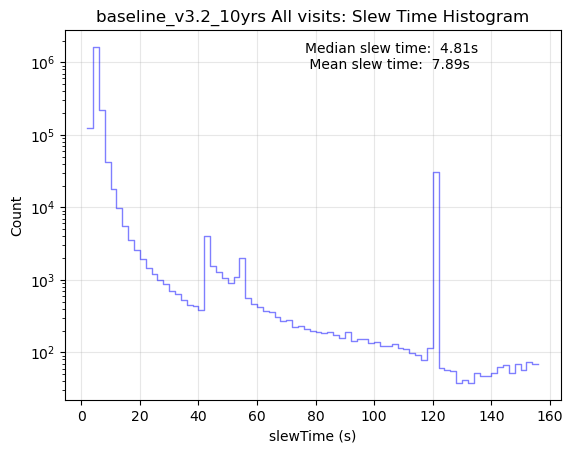

In [8]:
k = f"{run_name.replace('.', '_')}_Slew_Time_Histogram_All_visits_ONED"
b = slew_bundles[k]
label = f"Median slew time: {b2.metric_values[0]: .2f}s\n Mean slew time: {b1.metric_values[0]: .2f}s"
b.plot()
plt.figtext(0.5, 0.8, label)